## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from time import sleep
from IPython.display import clear_output

## Load in Data

In [ ]:
data = pd.read_csv('data.csv')

## Get the artist id and add it to the data set

In [ ]:
def get_token():
    '''
    Onbtain a token to use for requesting data from the Spotify API

    Parameter: None

    Returns : Token obtained from Spotify API
    '''
    CLIENT_ID = 'ea96b09aa2884f2bb2b4cc6c5de6872d'
    CLIENT_SECRET = '200fede79e1741edb0f4e76f7a5d8792'

    AUTH_URL = 'https://accounts.spotify.com/api/token'

    # POST
    auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
    })

    # convert the response to JSON
    auth_response_data = auth_response.json()

    # save the access token
    return auth_response_data['access_token']

In [ ]:
def get_artist_id(song_id, token):
    '''
    Obtain the Artist ID for a given song using the song's ID

    Parameters:
    song_id: string of the song ID
    token: an active, valid token to request data from the Spotify API

    Returns: Artist ID for the song
    '''
    headers = {
    'Authorization': 'Bearer {token}'.format(token=token)
    }

    song_url = "https://api.spotify.com/v1/tracks/" + song_id
    song_data = requests.get(url=song_url, headers=headers)
    return song_data.json()['artists'][0]['id']

In [ ]:
def get_monthly_listerners(artist_id):
    '''
    Obtains the number of monthly listeners for an artist given the artist ID

    Parameters:
    artist_id: a string of the artist ID 

    Returns: The number of monthly listeners if it is available on the artist's webpage     on Spotify, otherwise None. 
    '''
    try:
        DRIVER_PATH = 'chromedriver'

        options = Options()
        options.headless = True

        driver = webdriver.Chrome(options=options, executable_path=DRIVER_PATH)
        driver.get("https://open.spotify.com/artist/" + artist_id)

        listeners = driver.find_element_by_xpath("//span[@class='_85aaee9fc23ca61102952862a10b544c-scss']").get_attribute('innerHTML')
        driver.quit()

        return listeners[:-18]
    except:
        return None

In [ ]:
token = get_token()

In [ ]:
data['artist id'] = data['id'].apply(lambda x:0)

In [ ]:
start = 170000

In [ ]:
# Add a column to the original data containing the first artist's ID for each song
length = len(data['id'])
for i in range(length):
    try:
        print(f'{i} out of {length}')
        if i%1000==0:
           token = get_token()
           data["artist id"].to_csv('artist_id{}.csv'.format(start), index = False)
           start = i
        data["artist id"][i] = get_artist_id(data['id'][i],token)
        clear_output(wait=True)
    except:
        print('FAILED')
        data["artist id"][i] = None
data["artist id"].to_csv('artist_id{}.csv'.format(start), index = False)


170652 out of 170653


In [ ]:
data['monthly listeners'] = data['artist id'].apply(lambda x: 0)

In [ ]:
# Add a column to the original data containing the number of monthly listeners for the first artist of each song
length = len(data['artist id'])
for i in range(length):
    try:
        print(f'{i} out of {length}')
        data['monthly listeners'][i] = get_monthly_listerners(data['artist id'][i])
        if i%1000==0:
            data.to_csv('output2.csv', index = False)
    except:
        data['monthly listeners'][i] = None

In [ ]:
data['monthly listeners']

## Get an artists top 10 songs and their number of listens

In [ ]:
def get_top_songs_and_listens(artist_id):
    '''
    Get the top songs listed by the Spotify website for each artist and the            
    corresponding number of listens for each song given the artist ID

    Parameters:
    artist_id: a string of the artist ID 

    Returns: Tuple of 2 lists. The first list contains the names of the artist's top
    songs. The second list containd the corresponding number of listens per songs.
    '''
    DRIVER_PATH = '/Users/kevinyoussef/Desktop/ECE 225A/Project/chromedriver'

    options = Options()
    options.headless = True

    driver = webdriver.Chrome(options=options, executable_path=DRIVER_PATH)
    driver.maximize_window()
    driver.get("https://open.spotify.com/artist/"+artist_id)
    elem = driver.switch_to.active_element
    close = elem.find_element_by_xpath("//button[@aria-label='Close']")
    close.click()
    try:
        button = driver.find_element_by_xpath("//button[@aria-expanded='false']")
        button.click()
    except:
        pass

    names_list = []
    listens_list = []
    for i in range(10):
        try:
            row = driver.find_element_by_xpath("//div[@aria-rowindex='{}']".format(i+1))
            listens = row.find_element_by_class_name("d47b790d001ed769adcd9ddfc0e83acc-scss").get_attribute('innerHTML')
            name = row.find_element_by_class_name("da0bc4060bb1bdb4abb8e402916af32e-scss").get_attribute('innerHTML')
            listens_list.append(listens)
            names_list.append(name)
        except:
            listens_list.append(None)
            names_list.append(None)
    driver.quit()
    return names_list, listens_list

In [ ]:
data = pd.read_csv('data_with_artist_id.csv')

In [ ]:
# Start working with the data by artist instead of by song
data_by_artist = data.groupby(['artist_id']).mean()

In [ ]:
data_by_artist

,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
artist_id,,,,,,,,,,,,,,,
001aJOc7CSQVo3XzoLG4DK,0.636875,1993.625,0.21850,0.831875,304916.625000,0.476750,0.0,0.100375,7.000000,0.067388,-12.4060,0.750000,39.5,0.07810,108.147250
00608sMSbuz1IpmDzSrFZk,0.985000,1997.000,0.24200,0.814000,215440.000000,0.370000,0.0,0.000077,3.000000,0.065600,-11.6370,1.000000,39.0,0.04490,125.055000
006ZADyabxpgKqMmh8W2yz,0.368667,2019.000,0.03410,0.687667,317174.666667,0.781667,0.0,0.581167,6.666667,0.090767,-9.2220,0.333333,0.0,0.06700,130.013333
009IKtLg2rg2QMbvNtWaoh,0.529000,2007.000,0.00681,0.664000,258653.000000,0.686000,0.0,0.000000,5.000000,0.135000,-6.1730,0.000000,54.0,0.17400,86.352000
00Avn3gt1QPLXTFRSRhVmA,0.122000,1961.000,0.79600,0.369000,127427.000000,0.170000,0.0,0.000000,3.000000,0.091600,-18.3200,1.000000,24.0,0.03740,104.043000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7zsxdMsODmHKTbTB00t9wS,0.207000,1957.000,0.92300,0.417000,194960.000000,0.098000,0.0,0.001700,4.000000,0.131000,-15.6310,0.000000,21.0,0.03720,121.199000
7ztTFG2HLFxQKV3K0NN6HD,0.863000,1943.000,0.98700,0.451000,155267.000000,0.227000,0.0,0.040700,10.000000,0.130000,-17.1820,1.000000,0.0,0.05040,183.340000
7zuZaI5MMCKCiDMmtkp0kp,0.877000,1973.000,0.52500,0.688000,238561.000000,0.733000,0.0,0.017500,9.000000,0.140000,-5.7680,1.000000,42.0,0.24400,95.705000


In [ ]:
data = data_by_artist_final

In [ ]:
data.index[0]

'001aJOc7CSQVo3XzoLG4DK'

In [ ]:
data['Top Songs'] = data['year'].apply(lambda x: 0)
data['Top Songs'] = data['Top Songs'].astype('object')

In [ ]:
data['Top Songs Listens'] = data['year'].apply(lambda x: 0)
data['Top Songs Listens'] = data['Top Songs Listens'].astype('object')

In [ ]:
# Add two columns to the data. The first is a list of the artist's top songs. The second is a list of the corresponding number of listens for the top songs.
# Have to use for loops because we are sending API request and hence we can't vectorize it
length = len(data.index)
start = 0
for i in range(0,length):
    try:
        print(f'{i} out of {length}')
        data['Top Songs'][i], data['Top Songs Listens'][i] =get_top_songs_and_listens(data.index[i])
        if i%10==0:
            data['Top Songs'].to_csv('top{}.csv'.format(i), index = False)
            data['Top Songs Listens'].to_csv('top_listens{}.csv'.format(i), index = False)
        clear_output(wait=True)
    except:
        print("FAILED")
        data['Top Songs'][i] = None 
        data['Top Songs Listens'][i] = None
data['Top Songs'].to_csv('top{}.csv'.format(i), index = False)
data['Top Songs Listens'].to_csv('top_listens{}.csv'.format(i), index = False)

2579 out of 20646


## Construct Final Dataset

In [ ]:
def get_first_name(x):
    '''
    Get the first name from a string of a full name

    Parameters:
    x: String of a full name seprated by a space

    Returns: a string of the first name
    '''
    if type(x) is float:
        return ''
    return x[0].strip('][').split(', ')[0].replace("'",'')

In [ ]:
def string_to_list(x):
    '''
    Creates a list out of a string of comma seperated strings
    
    Parameters: 
    x: the string of the comma seperated strings

    Returns: a list containing the comma seperated strings
    '''
    if x == '[]':
        return None
    if type(x) is float:
        return None
    x = x.strip('][').split(', ')
    return [x[i].replace("'",'') for i in range(len(x))]

In [ ]:
def string_to_int(x):
    '''
    Turns a string of an integer to type int

    Parameters:
    x: string of an integer

    Returns: integer type number
    '''
    if type(x) is str:
        return int(''.join(i for i in x if i.isdigit()))

In [ ]:
def group_genres(x):
    '''
    Gets the list of genres a song is classified as from a select number of genres. If 
    the song does not belong to one of the select genres, it gets the genre of 'Other'

    Parameters:
    x: list of strings of different genres

    Returns: list of strings of the select genres
    '''
    output = []
    #print(x)
    if x is None:
        return None
    genres_list = ['pop','hip hop','rap','edm','trance','house','electro','dubstep','hard style','rock','jazz','classical','latin','metal','rhythm and blues','r&b','country','punk','mexican','disco','indie','reggaeton','spanish','disney','blues','christmas','christian','worship','gospel']
    classification_dict = {0:'Pop',1:'Hip Hop/Rap',2:'Hip Hop/Rap',3:'Electronic',4:'Electronic',5:'Electronic',6:'Electronic',7:'Electronic',8:'Electronic',9:'Rock',10:'Jazz',11:'Classical',12:'Latin',13:'Metal',14:'R&B',15:'R&B',16:'Country',17:'Punk',18:'Latin',19:'Disco',20:'Indie',21:'Latin',22:'Latin',23:'Disney',24:'R&B',25:'Christmas',26:'Christian',27:'Christian',28:'Christian'}
    for i in range(len(genres_list)):
        if any(genres_list[i] in elem for elem in x):
            output.append(classification_dict[i])
    if output == []:
        output.append('Other')
    return output

In [ ]:
# Add a column of the select genres for each song
song_data = pd.read_csv('Final Data/data_with_artist_id.csv')
artist_data = pd.read_csv('Final Data/genres.csv')
artist_data['Genres'] = artist_data['Genres'].apply(string_to_list)
artist_data['artist_id'] = song_data.groupby('artist_id').mean().index

artist_data['Name'] = song_data.loc[:,['artists','artist_id']].groupby('artist_id')['artists'].apply(lambda x: "[%s]" % ', '.join(x)).apply(string_to_list).apply(get_first_name).reset_index()['artists']
artist_data = artist_data[['Name', 'Genres', 'artist_id']]
artist_data['Monthly Listeners'] = pd.read_csv('Final Data/monthly.csv')['Monthly Listeners'].apply(string_to_int).apply(lambda x:int(x) if x > 0 else x)
artist_data['Main Genres'] = artist_data['Genres'].apply(group_genres)

In [ ]:
artist_data

,Name,Genres,artist_id,Monthly Listeners,Main Genres
0,One Way,"[classic soul, electro, funk, motown, post-dis...",001aJOc7CSQVo3XzoLG4DK,371666.0,"[Electronic, Disco]"
1,Banda Boom,None,00608sMSbuz1IpmDzSrFZk,32948.0,None
2,Vyacheslav Sketch,None,006ZADyabxpgKqMmh8W2yz,647.0,None
3,Pressure,[virgin islands reggae],009IKtLg2rg2QMbvNtWaoh,150495.0,[Other]
4,LARGE KALLIOPE WITH BELLS,None,00Avn3gt1QPLXTFRSRhVmA,3789.0,None
...,...,...,...,...,...
20641,Dorival Caymmi,"[bossa nova, choro, forro, mpb, musica infanti...",7zsxdMsODmHKTbTB00t9wS,NaN,[Other]
20642,Helge Leonhard,None,7ztTFG2HLFxQKV3K0NN6HD,NaN,None
20643,The Honey Drippers,None,7zuZaI5MMCKCiDMmtkp0kp,28081.0,None
20644,Fayza Ahmed,"[classic arab pop, syrian pop]",7zwF847GE2hY5ApGSOLmBG,13865.0,[Pop]


In [ ]:
artist_data.to_csv('artist_data.csv',index = False)

## Data Analysis

### Finding Most Popular Genres By Artist Monthly Listeners

In [ ]:
def check_if_genre_exists(x):
    if x is None:
        return None
    return i in x

In [ ]:
classification_dict = {0:'Pop',1:'Hip Hop/Rap',2:'Hip Hop/Rap',3:'Electronic',4:'Electronic',5:'Electronic',6:'Electronic',7:'Electronic',8:'Electronic',9:'Rock',10:'Jazz',11:'Classical',12:'Latin',13:'Metal',14:'R&B',15:'R&B',16:'Country',17:'Punk',18:'Latin',19:'Disco',20:'Indie',21:'Latin',22:'Latin',23:'Disney',24:'R&B',25:'Christmas',26:'Christian',27:'Christian',28:'Christian'}
hist = pd.DataFrame()
for i in list(set(classification_dict.values()))+['Other']:
    hist[str(i)] = artist_data['Main Genres'].apply(check_if_genre_exists) * artist_data['Monthly Listeners']

In [ ]:
sums = hist.dropna().sum()[1:]
sums.sort_values(ascending=False)

Pop            9.949993e+09
Hip Hop/Rap    4.525977e+09
Rock           4.399561e+09
Electronic     2.276454e+09
Latin          2.035806e+09
Indie          1.642607e+09
R&B            1.480960e+09
Other          1.166133e+09
Country        8.916228e+08
Metal          6.589161e+08
Punk           5.024655e+08
Jazz           4.334205e+08
Disco          3.147073e+08
Classical      1.872687e+08
Disney         3.482259e+07
Christmas      2.545241e+07
dtype: float64

Text(0, 0.5, 'Total Number Of Monthly Listeners')

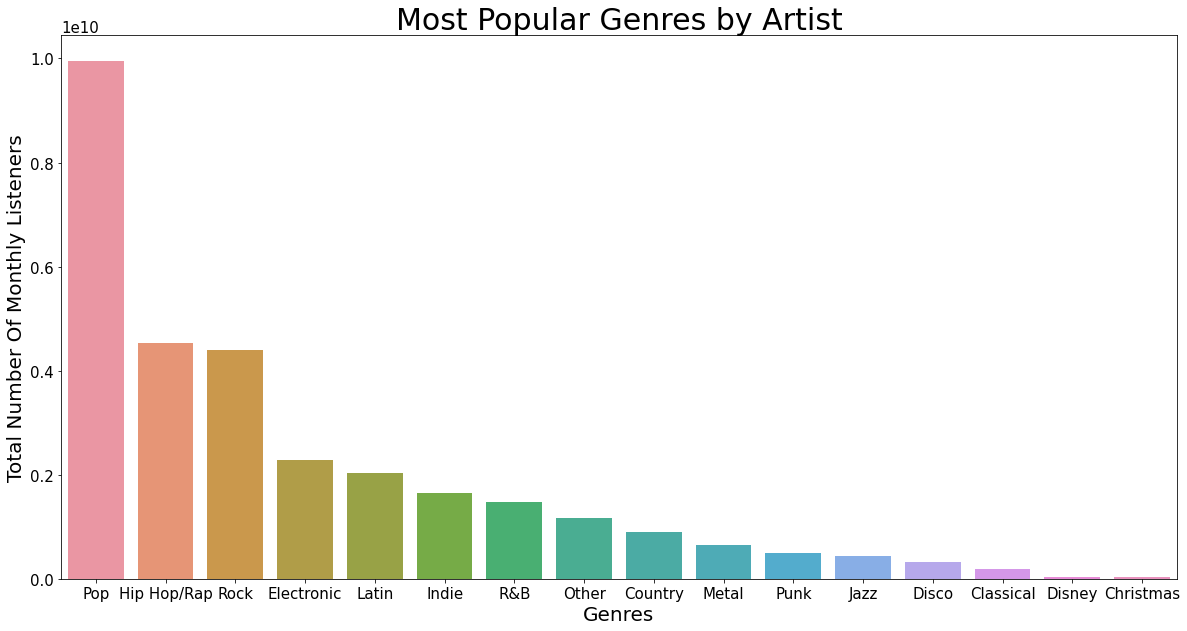

In [ ]:
plt.figure(figsize=(20,10))
plt.rc('font', size=15) 
sns.barplot(sums.sort_values(ascending=False).index,sums.sort_values(ascending=False).values)
plt.title('Most Popular Genres by Artist',fontsize=30)
plt.xlabel('Genres',fontsize=20)
plt.ylabel('Total Number Of Monthly Listeners',fontsize=20)

### Most Popular Artists

In [ ]:
highest = artist_data.loc[artist_data['Monthly Listeners'].nlargest(20).index.tolist()]
highest['Name'] = highest['Name'].apply(lambda x: x.replace(' ', '\n'))
highest

,Name,Genres,artist_id,Monthly Listeners,Main Genres
5086,Justin\nBieber,"[canadian pop, pop, post-teen pop]",1uNFoZAHBGtllmzznpCI3s,75694791.0,[Pop]
4188,The\nWeeknd,"[canadian contemporary r&b, canadian pop, pop]",1Xyo4u8uXC1ZmMpatF05PJ,65816702.0,"[Pop, R&B]"
5140,J\nBalvin,"[latin, reggaeton, reggaeton colombiano]",1vyhD5VmyZ7KMfW5gqLgo5,58111068.0,"[Latin, Latin]"
18177,Billie\nEilish,"[electropop, pop]",6qqNVTkY8uBg9cP3Jd7DAH,53116812.0,"[Pop, Electronic]"
20074,Shawn\nMendes,"[canadian pop, dance pop, pop, post-teen pop, ...",7n2wHs1TKAczGzO7Dd2rGr,52607217.0,[Pop]
12891,Bad\nBunny,"[latin, reggaeton, trap latino]",4q3ewBCX7sLwd24euuV69X,51031955.0,"[Hip Hop/Rap, Latin, Latin]"
12551,Mariah\nCarey,"[dance pop, pop, r&b, urban contemporary]",4iHNK0tOyZPYnBU7nGAgpQ,46356411.0,"[Pop, R&B]"
16832,Khalid,"[alternative r&b, pop]",6LuN9FCkKOj5PcnpouEgny,46131353.0,"[Pop, R&B]"
14730,Miley\nCyrus,"[dance pop, pop, pop dance, post-teen pop]",5YGY8feqx7naU7z4HrwZM6,45754886.0,[Pop]
14660,Sia,"[australian dance, australian pop, dance pop, ...",5WUlDfRSoLAfcVSX1WnrxN,44599740.0,[Pop]


(40000000.0, 80000000.0)

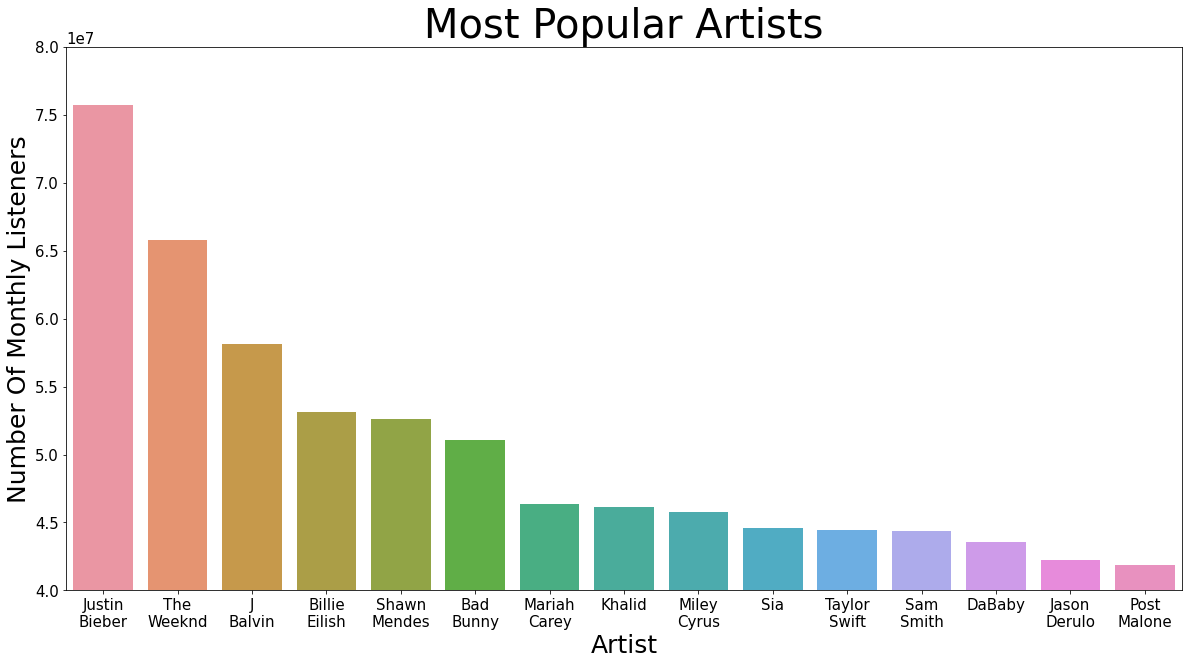

In [ ]:
plt.figure(figsize=(20,10))
plt.rc('font', size=15) 
sns.barplot(x = 'Name', y = 'Monthly Listeners', data = highest[:][:15])
plt.title('Most Popular Artists',fontsize=40)
plt.xlabel('Artist',fontsize=25)
plt.ylabel('Number Of Monthly Listeners',fontsize=25)
plt.ylim([4*10**7,8*10**7]) 

### Explicit Words Effect On Popularity

In [ ]:
song_data = pd.read_csv('Final Data/data.csv')
song_data.groupby('explicit').mean()

,valence,year,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
explicit,,,,,,,,,,,,,,
0,0.530076,1975.047177,0.530233,0.524452,232822.082608,0.471592,0.180443,5.194040,0.203732,-11.710978,0.717815,30.161042,0.077911,116.749867
1,0.512472,1995.621354,0.197773,0.677490,210666.965634,0.599257,0.021608,5.262662,0.228635,-8.837937,0.588790,45.186171,0.320089,118.070856


([<matplotlib.patches.Wedge at 0x7fd2fe2ba730>,
 [Text(0.35435908342908623, 1.0940427962339034, 'Non-Explicit'),
  Text(-0.35435918586076404, -1.0940427630564067, 'Explicit')],
 [Text(0.20028991672078783, 0.618372015262641, '40.0%'),
  Text(-0.20028997461695358, -0.6183719965101427, '60.0%')])

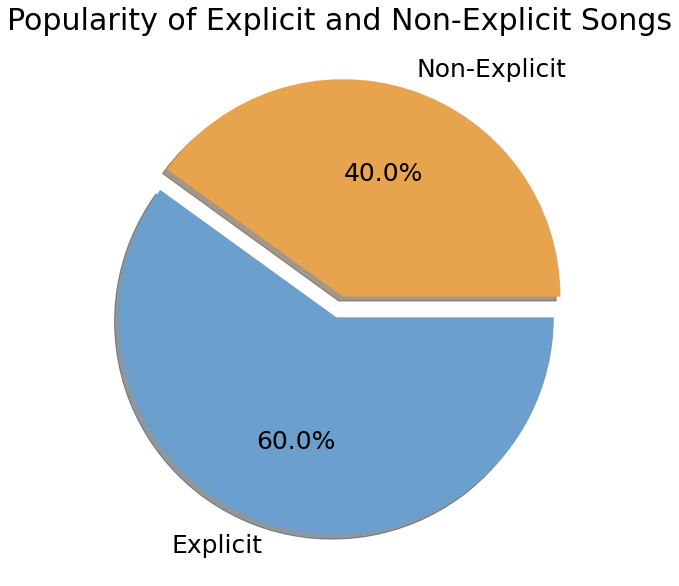

In [ ]:
plt.figure(figsize=(10,10))
plt.title('Popularity of Explicit and Non-Explicit Songs',fontsize=30)
plt.pie(song_data.groupby('explicit').mean()['popularity'],explode=[0.05]*2,labels=['Non-Explicit','Explicit'],autopct="%.1f%%",shadow=True,textprops={'fontsize':25},colors = ['#e8a34e','#6a9fce'])

### Combine Artist Data Set

In [ ]:
kaggle = pd.read_csv('Final Data/data_by_artist.csv')
kaggle = kaggle.rename(columns={'artists':'Name'})
kaggle 

,mode,count,acousticness,Name,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,9,0.590111,"""Cats"" 1981 Original London Cast",0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5
1,1,26,0.862538,"""Cats"" 1983 Broadway Cast",0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5
2,1,7,0.856571,"""Fiddler On The Roof” Motion Picture Chorus",0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0
3,1,27,0.884926,"""Fiddler On The Roof” Motion Picture Orchestra",0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.851852,0
4,1,7,0.510714,"""Joseph And The Amazing Technicolor Dreamcoat""...",0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,43.000000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28675,1,2,0.512000,麥志誠,0.356000,198773.000000,0.306000,0.008970,0.108000,-10.119000,0.027700,150.049000,0.328000,35.000000,10
28676,0,2,0.541000,黃品源,0.578000,293840.000000,0.334000,0.000006,0.067500,-11.974000,0.026700,135.934000,0.243000,48.000000,9
28677,1,11,0.785455,黃國隆,0.570818,174582.727273,0.148400,0.000083,0.142191,-21.610091,0.054355,119.586273,0.741273,23.000000,5
28678,1,2,0.381000,黑豹,0.353000,316160.000000,0.686000,0.000000,0.056800,-9.103000,0.039500,200.341000,0.352000,35.000000,11


In [ ]:
pd.merge(kaggle,artist_data,how='inner',on='Name').to_csv('artist_data_combined.csv')

### Coroleation Of different Features

<Figure size 1440x720 with 0 Axes>

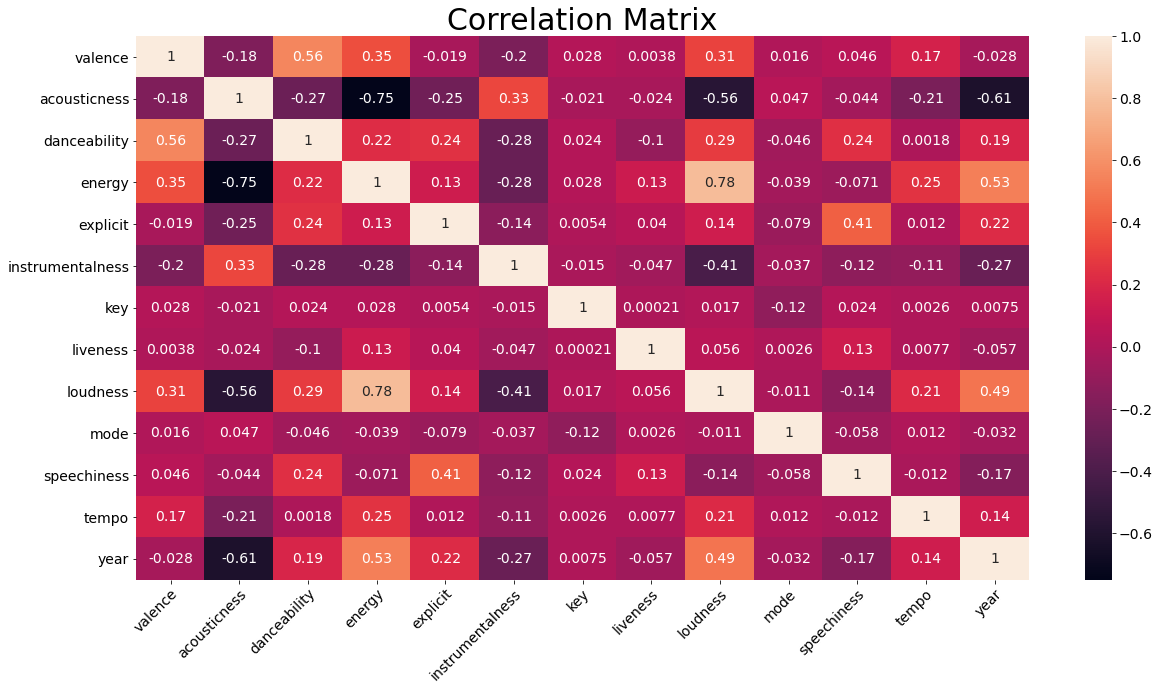

In [ ]:
all_features = song_data[['valence','acousticness','danceability','energy','explicit','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','year']]
plt.figure(figsize=(20,10))
plt.figure(figsize=((20,10)))
sns.heatmap(all_features.corr(),annot=True)
plt.title("Correlation Matrix",fontsize=30)
plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
_ = plt.axis(off=True)

## Determining Most Important Features Of A Song

In [ ]:
features = song_data[['valence','acousticness','danceability','energy','explicit','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','year']]
popularity = song_data['popularity']

Text(0.5, 0, 'Features')

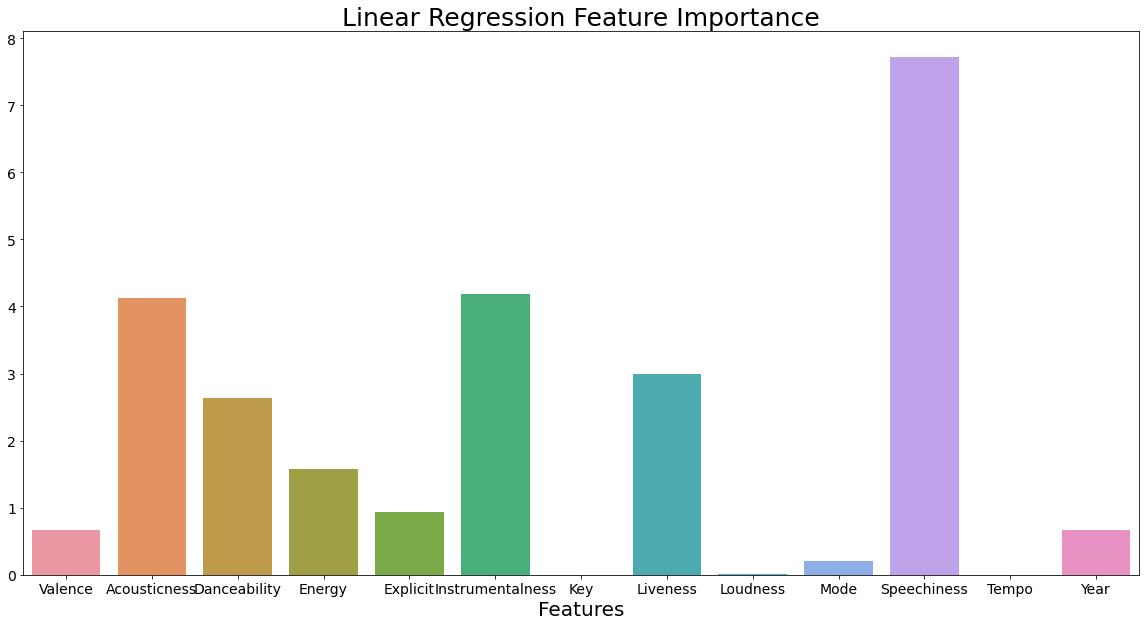

In [ ]:
model = LinearRegression()
model.fit(features,popularity)
plt.figure(figsize=(20,10))
plt.rc('font',size = 14)
sns.barplot([x.capitalize() for x in features.columns.tolist()],[abs(x) for x in model.coef_],)
plt.title('Linear Regression Feature Importance',fontsize=25)
plt.xlabel('Features',fontsize=20)

In [ ]:
model = LogisticRegression()
model.fit(features,popularity)

LogisticRegression()

Text(0.5, 0, 'Features')

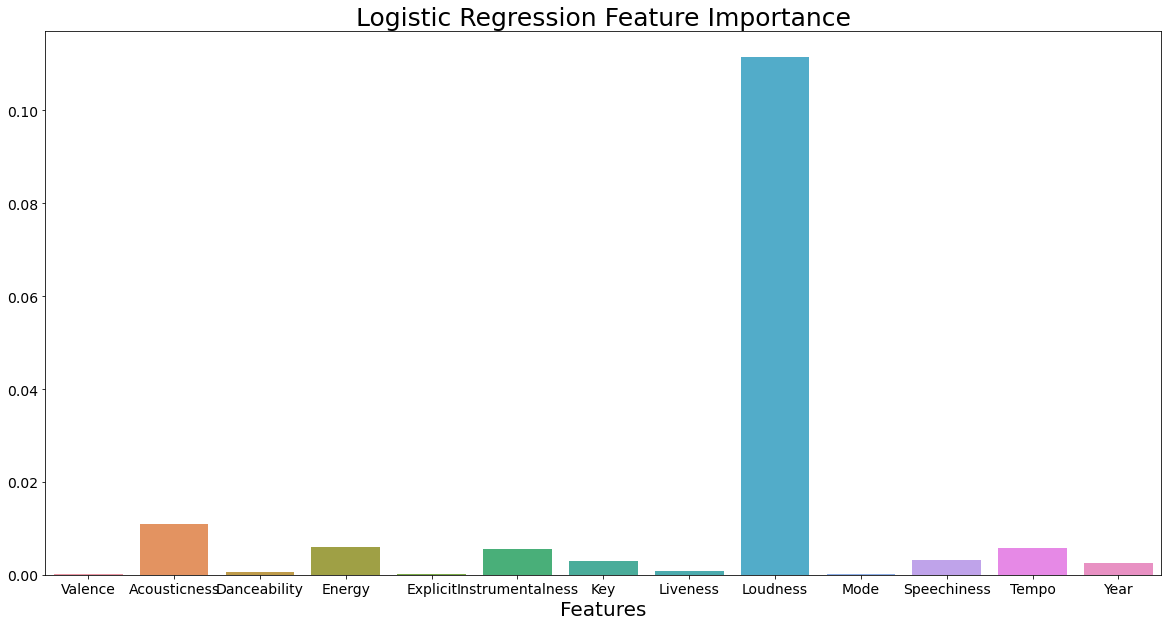

In [ ]:
plt.figure(figsize=(20,10))
plt.rc('font',size = 14)
sns.barplot([x.capitalize() for x in features.columns.tolist()],[abs(x) for x in model.coef_[0]],)
plt.title('Logistic Regression Feature Importance',fontsize=25)
plt.xlabel('Features',fontsize=20)

Text(0.5, 0, 'Features')

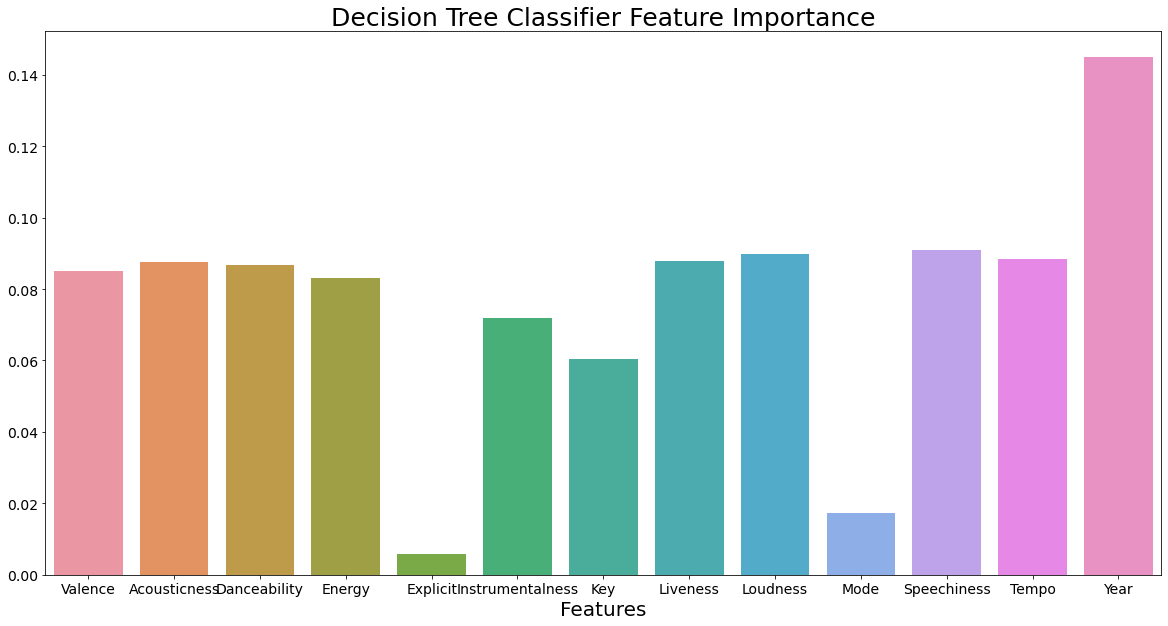

In [ ]:
model = DecisionTreeClassifier()
model.fit(features,popularity)
plt.figure(figsize=(20,10))
plt.rc('font',size = 14)
sns.barplot([x.capitalize() for x in features.columns.tolist()],[x for x in model.feature_importances_],)
plt.title('Decision Tree Classifier Feature Importance',fontsize=25)
plt.xlabel('Features',fontsize=20)

## Using Features To Predict Popularity Of Songs

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, popularity, test_size = 0.20)

#### Linear Regression No Scaling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, popularity, test_size = 0.20)
reg = LinearRegression().fit(X_train,y_train)
reg.predict(X_test)
print('Score is %.2f' % (100*reg.score(X_test,y_test)) +'%')

Score is 75.13%


#### Linear Regression Standard Scaling

In [ ]:
scaled = StandardScaler().fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(scaled, popularity, test_size = 0.20)
reg = LinearRegression().fit(X_train,y_train)
reg.predict(X_test)
print('Score is %.2f' % (100*reg.score(X_test,y_test)) +'%')

Score is 75.16%


In [ ]:
def quantize(x):
    if x<=25:
        return 0
    if 25<x<=50:
        return 1
    if 50<x<=75:
        return 2
    else:
        return 3

#### KNN With Scaling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(scaled, song_data['popularity'].apply(quantize), test_size = 0.20)
classifier = KNeighborsClassifier(n_neighbors=100)
classifier.fit(X_train, y_train)
print(classification_report(y_test,classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85     13233
           1       0.67      0.78      0.72     13654
           2       0.66      0.51      0.57      6881
           3       0.00      0.00      0.00       363

    accuracy                           0.74     34131
   macro avg       0.55      0.53      0.54     34131
weighted avg       0.73      0.74      0.73     34131



#### Linear Regression with PCA

In [ ]:
pca_data = PCA().fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(pca_data, popularity, test_size = 0.20)
reg = LinearRegression().fit(X_train,y_train)
reg.predict(X_test)
print('Score is %.2f' % (100*reg.score(X_test,y_test)) +'%')

Score is 75.42%


#### KNN with PCA

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pca_data, song_data['popularity'].apply(quantize), test_size = 0.20)
classifier = KNeighborsClassifier(n_neighbors=100)
classifier.fit(X_train, y_train)
print(classification_report(y_test,classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87     12980
           1       0.69      0.84      0.76     13692
           2       0.72      0.51      0.60      7136
           3       0.00      0.00      0.00       323

    accuracy                           0.77     34131
   macro avg       0.58      0.55      0.56     34131
weighted avg       0.77      0.77      0.76     34131



### Using Select Features

In [ ]:
select_features = features[['acousticness','danceability','instrumentalness','loudness','speechiness','year']]
popularity = song_data['popularity']

#### Linear Regression without Scaling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(select_features, popularity, test_size = 0.20)
reg = LinearRegression().fit(X_train,y_train)
reg.predict(X_test)
print('Score is %.2f' % (100*reg.score(X_test,y_test)) +'%')

Score is 75.39%


#### Linear Regression with Scaling

In [ ]:
scaled = StandardScaler().fit_transform(select_features)
X_train, X_test, y_train, y_test = train_test_split(scaled, popularity, test_size = 0.20)
reg = LinearRegression().fit(X_train,y_train)
reg.predict(X_test)
print('Score is %.2f' % (100*reg.score(X_test,y_test)) +'%')

Score is 75.36%


#### KNN with Scaling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(scaled, song_data['popularity'].apply(quantize), test_size = 0.20)
classifier = KNeighborsClassifier(n_neighbors=100)
classifier.fit(X_train, y_train)
print(classification_report(y_test,classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87     13136
           1       0.69      0.81      0.75     13794
           2       0.69      0.52      0.59      6854
           3       0.00      0.00      0.00       347

    accuracy                           0.76     34131
   macro avg       0.56      0.55      0.55     34131
weighted avg       0.76      0.76      0.75     34131



#### Linear Regression with PCA

In [ ]:
pca_data = PCA().fit_transform(select_features)
X_train, X_test, y_train, y_test = train_test_split(pca_data, popularity, test_size = 0.20)
reg = LinearRegression().fit(X_train,y_train)
reg.predict(X_test)
print('Score is %.2f' % (100*reg.score(X_test,y_test)) +'%')

Score is 75.28%


#### KNN with PCA

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pca_data, song_data['popularity'].apply(quantize), test_size = 0.20)
classifier = KNeighborsClassifier(n_neighbors=100)
classifier.fit(X_train, y_train)
print(classification_report(y_test,classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87     12993
           1       0.70      0.84      0.76     13913
           2       0.71      0.51      0.59      6893
           3       0.50      0.02      0.04       332

    accuracy                           0.77     34131
   macro avg       0.70      0.56      0.57     34131
weighted avg       0.77      0.77      0.76     34131

